In [1]:
import numpy as np
import os
import six.moves.urllib as urllib
import sys
import tarfile
import tensorflow as tf
import zipfile
import cv2
import time

from collections import defaultdict
from io import StringIO
import matplotlib.pyplot as plt
from PIL import Image
import os.path

%matplotlib inline

In [2]:
from utils import label_map_util
from utils import visualization_utils as vis_util

from fashion_utils import *

In [3]:
sys.path.append("..")

Model preparation 

Any model exported using the `export_inference_graph.py` tool can be loaded here simply by changing `PATH_TO_CKPT` to point to a new .pb file.  
By default we use an "SSD with Mobilenet" model here. See the [detection model zoo](https://github.com/tensorflow/models/blob/master/object_detection/g3doc/detection_model_zoo.md) for a list of other models that can be run out-of-the-box with varying speeds and accuracies.


In [4]:
# What model to download.

MODEL_NAME = 'trained-inference-graphs/output_inference_graph_v1.pb/'

# Path to frozen detection graph. This is the actual model that is used for the object detection.
PATH_TO_CKPT = MODEL_NAME + '/frozen_inference_graph.pb'

# List of the strings that is used to add correct label for each box.
PATH_TO_LABELS = os.path.join('training/', 'clothing-detection.pbtxt')

NUM_CLASSES = 1

In [5]:
## Load a (frozen) Tensorflow model into memory.
detection_graph = tf.Graph()
with detection_graph.as_default():
    od_graph_def = tf.GraphDef()
    with tf.gfile.GFile(PATH_TO_CKPT, 'rb') as fid:
        serialized_graph = fid.read()
        od_graph_def.ParseFromString(serialized_graph)
        tf.import_graph_def(od_graph_def, name='')

In [6]:
## Loading label map
label_map = label_map_util.load_labelmap(PATH_TO_LABELS)
categories = label_map_util.convert_label_map_to_categories(label_map, max_num_classes=NUM_CLASSES, use_display_name=True)
category_index = label_map_util.create_category_index(categories)

So we ran the whole process below with the complete dataset and got 63% accuracy, but that is because most of the images in labeled images in wild dataset has only one image per person, so when the image of person in test set is not present in training set then we will always get incorrect ans.

The original labeled images in the wild dataset has ~13k images. Selecting a smaller set of images by choosing people with more than 10 images, for analysis.

In [7]:
len(os.listdir('img'))

123016

In [8]:
class IdentityMetadata():
    def __init__(self, name, file):
        # identity name
        self.name = name
        # image file name
        self.file = file

    def __repr__(self):
        return self.image_path()

    def image_path(self):
        return os.path.join(self.name, self.file) 
    
def load_metadata(path):
    metadata = []
    for f in os.listdir(path):
        # Check file extension. Allow only jpg/jpeg' files.
        ext = os.path.splitext(f)[1]
        if ext == '.jpg' or ext == '.jpeg':
            metadata.append(IdentityMetadata(path,f))
    return np.array(metadata)


In [9]:
### images 
IMAGE_PATHS = load_metadata('img')
IMAGE_PATHS

array([img/img_00117352.jpg, img/img_00024108.jpg, img/img_00096643.jpg,
       ..., img/img_00008259.jpg, img/img_00084517.jpg,
       img/img_00096558.jpg], dtype=object)

In [10]:
from progressbar import ProgressBar
import warnings
warnings.filterwarnings('ignore')
# from model import create_model

# nn4_small2_pretrained = create_model()
# nn4_small2_pretrained.load_weights('weights/nn4.small2.v1.h5')

num_images = IMAGE_PATHS.shape[0]
print(num_images)

123016


In [13]:
IMAGE_PATHS = IMAGE_PATHS[:200]

### Face Detection

In [14]:
num_images = IMAGE_PATHS.shape[0]
progress = ProgressBar(num_images)
progress.start()

faces = []
temp_paths = []
with detection_graph.as_default():
    with tf.Session(graph=detection_graph) as sess:
        for i,image_path in enumerate(IMAGE_PATHS):
            image = Image.open(str(image_path))
            image_np = load_image_into_numpy_array(image)
            ## Expand dimensions since the model expects images to have shape: [1, None, None, 3]
            image_np_expanded = np.expand_dims(image_np, axis=0)
            image_tensor = detection_graph.get_tensor_by_name('image_tensor:0')
            ## Each box represents a part of the image where a particular object was detected.
            boxes = detection_graph.get_tensor_by_name('detection_boxes:0')
            
            ## Each score represent how level of confidence for each of the objects.
            ## Score is shown on the result image, together with the class label.
            scores = detection_graph.get_tensor_by_name('detection_scores:0')
            classes = detection_graph.get_tensor_by_name('detection_classes:0')
            num_detections = detection_graph.get_tensor_by_name('num_detections:0')
            ## Actual detection.
            (boxes, scores, classes, num_detections) = sess.run(
                [boxes, scores, classes, num_detections],
                feed_dict={image_tensor: image_np_expanded})
            
            ## Visualization of the results of a detection.
            temp = vis_util.extract_faces_from_image_array(
                image_np,
                np.squeeze(boxes),
                np.squeeze(classes).astype(np.int32),
                np.squeeze(scores),
                category_index,
                use_normalized_coordinates=True,
                line_thickness=8)
            
            temp = np.array(temp)
            if(temp.shape[0]>0):
                temp_paths.append(image_path)
                face = extract_face(image,temp)
                faces.append(face)
            progress.update(i)
            
IMAGE_PATHS = temp_paths

In [15]:
np.save("fashion.npy",faces)
# faces = np.load('faces.npy', allow_pickle=True)

In [16]:
len(faces)

140

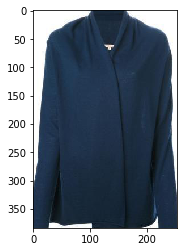

In [38]:
%matplotlib inline
plt.imshow(faces[31])

------------------------

# Face Embeddings

### keras Inception model

In [25]:
# embedded = np.zeros((num_images, 128))

# interpreter = tf.lite.Interpreter(model_path="converted_model.tflite")
# interpreter.allocate_tensors()

# input_details = interpreter.get_input_details()
# output_details = interpreter.get_output_details()

# input_shape = input_details[0]['shape']

### Inception resnet model

In [26]:
num_images = len(IMAGE_PATHS)
num_images

137

In [27]:
num_images = len(IMAGE_PATHS)
embedded = np.zeros((num_images, 512))

interpreter = tf.lite.Interpreter(model_path="resnet_quantized_model.tflite")
interpreter.allocate_tensors()

input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

input_shape = input_details[0]['shape']

In [28]:
num_faces = len(faces)
print("num_faces: ",num_faces)

num_im = len(IMAGE_PATHS)
print("num_im: ",num_im)

num_faces:  137
num_im:  137


In [29]:
IMAGE_PATHS[:10]

[face-recognition-images/Britney_Spears/Britney_Spears_0002.jpg,
 face-recognition-images/Britney_Spears/Britney_Spears_0004.jpg,
 face-recognition-images/Britney_Spears/Britney_Spears_0005.jpg,
 face-recognition-images/Britney_Spears/Britney_Spears_0008.jpg,
 face-recognition-images/Britney_Spears/Britney_Spears_0007.jpg,
 face-recognition-images/Britney_Spears/Britney_Spears_0010.jpg,
 face-recognition-images/Britney_Spears/Britney_Spears_0006.jpg,
 face-recognition-images/Britney_Spears/Britney_Spears_0003.jpg,
 face-recognition-images/Britney_Spears/Britney_Spears_0009.jpg,
 face-recognition-images/Britney_Spears/Britney_Spears_0001.jpg]

In [30]:
num_faces = len(faces)
progress = ProgressBar(num_faces)
progress.start()
for i,f in enumerate(faces):
    f = (f / 255.).astype(np.float32)
    f = np.expand_dims(cv2.resize(f, (160,160)), axis=0)
    ##f = np.expand_dims(cv2.resize(f, (96,96)), axis=0)
    interpreter.set_tensor(input_details[0]['index'], f)
    interpreter.invoke()
    embedded[i] = interpreter.get_tensor(output_details[0]['index'])
    progress.update(i)

In [31]:
np.save("embeddings_celeb",embedded)
# embedded = np.load('embeddings.npy')

### Visualizing embeddings/ results

The two cells below are too expensive for bigger datasets

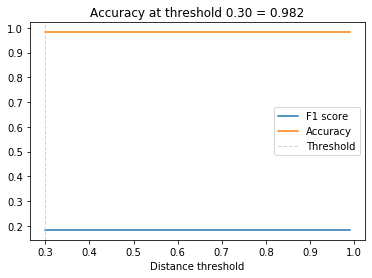

In [23]:
from sklearn.metrics import f1_score, accuracy_score

distances = [] # squared L2 distance between pairs
identical = [] # 1 if same identity, 0 otherwise

num = len(IMAGE_PATHS)

## This is super expensive O(n2)
for i in range(num - 1):
    for j in range(1, num):
        distances.append(distance(embedded[i], embedded[j]))
        identical.append(1 if IMAGE_PATHS[i].name == IMAGE_PATHS[j].name else 0)
        
distances = np.array(distances)
identical = np.array(identical)

thresholds = np.arange(0.3, 1.0, 0.01)

f1_scores = [f1_score(identical, distances < t) for t in thresholds]
acc_scores = [accuracy_score(identical, distances < t) for t in thresholds]

opt_idx = np.argmax(f1_scores)
# Threshold at maximal F1 score
opt_tau = thresholds[opt_idx]
# Accuracy at maximal F1 score
opt_acc = accuracy_score(identical, distances < opt_tau)

# Plot F1 score and accuracy as function of distance threshold
plt.plot(thresholds, f1_scores, label='F1 score');
plt.plot(thresholds, acc_scores, label='Accuracy');
plt.axvline(x=opt_tau, linestyle='--', lw=1, c='lightgrey', label='Threshold')
plt.title(f'Accuracy at threshold {opt_tau:.2f} = {opt_acc:.3f}');
plt.xlabel('Distance threshold')
plt.legend()
plt.show()

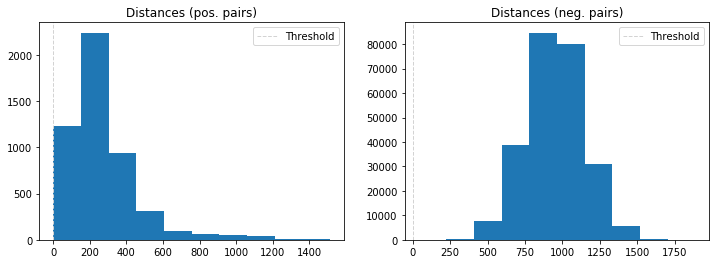

In [24]:
dist_pos = distances[identical == 1]
dist_neg = distances[identical == 0]

plt.figure(figsize=(12,4))

plt.subplot(121)
plt.hist(dist_pos)
plt.axvline(x=opt_tau, linestyle='--', lw=1, c='lightgrey', label='Threshold')
plt.title('Distances (pos. pairs)')
plt.legend()

plt.subplot(122)
plt.hist(dist_neg)
plt.axvline(x=opt_tau, linestyle='--', lw=1, c='lightgrey', label='Threshold')
plt.title('Distances (neg. pairs)')
plt.legend()
plt.show()

In [25]:
from sklearn.preprocessing import LabelEncoder
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import LinearSVC

targets = np.array([m.name for m in IMAGE_PATHS])

encoder = LabelEncoder()
encoder.fit(targets)

# Numerical encoding of identities
y = encoder.transform(targets)

### Testing

In [26]:
### testing 
test_idx = np.arange(len(IMAGE_PATHS)) % 2 != 0
train_idx = np.arange(len(IMAGE_PATHS)) % 2 == 0

X_train = embedded[train_idx]
X_test = embedded[test_idx]

y_train = y[train_idx]
y_test = y[test_idx]

In [27]:
from sklearn.metrics import f1_score, accuracy_score

In [28]:
knn = KNeighborsClassifier(n_neighbors=5, metric='euclidean')
knn.fit(X_train, y_train)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='euclidean',
                     metric_params=None, n_jobs=None, n_neighbors=5, p=2,
                     weights='uniform')

In [29]:
y_pred_knn = knn.predict(X_test)
acc_knn = accuracy_score(y_test, y_pred_knn)
print(f'KNN accuracy = {acc_knn}')

KNN accuracy = 0.9761904761904762


In [30]:
svc = LinearSVC()
svc.fit(X_train, y_train)

LinearSVC(C=1.0, class_weight=None, dual=True, fit_intercept=True,
          intercept_scaling=1, loss='squared_hinge', max_iter=1000,
          multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
          verbose=0)

In [31]:
y_pred_svc = svc.predict(X_test)
acc_svc = accuracy_score(y_test, y_pred_svc)

In [32]:
print(f'SVM accuracy = {acc_svc}')

SVM accuracy = 0.9404761904761905


In [33]:
IMAGE_PATHS = np.array(IMAGE_PATHS)

In [34]:
%matplotlib inline
def show_predictions_test(indexes):
    plt.figure(figsize=(16,16))
    
    for i, idx in enumerate(indexes[:16]):
        example_image = load_image(IMAGE_PATHS[test_idx][idx].image_path())
        print(IMAGE_PATHS[test_idx][idx].image_path())
        example_prediction = knn.predict([embedded[test_idx][idx]])
        example_identity = encoder.inverse_transform(example_prediction)[0]

        plt.subplot(4,4,i+1)
        plt.imshow(example_image)
        plt.title(f'Recognized as {example_identity}'); 

37
16
8
8
8
37
[47, 153, 184, 194, 210, 250]
labeled-faces-in-wild/Rudolph_Giuliani/Rudolph_Giuliani_0013.jpg
labeled-faces-in-wild/Hugo_Chavez/Hugo_Chavez_0067.jpg
labeled-faces-in-wild/Alejandro_Toledo/Alejandro_Toledo_0023.jpg
labeled-faces-in-wild/Gloria_Macapagal_Arroyo/Gloria_Macapagal_Arroyo_0020.jpg
labeled-faces-in-wild/Jean_Chretien/Jean_Chretien_0016.jpg
labeled-faces-in-wild/Hans_Blix/Hans_Blix_0003.jpg


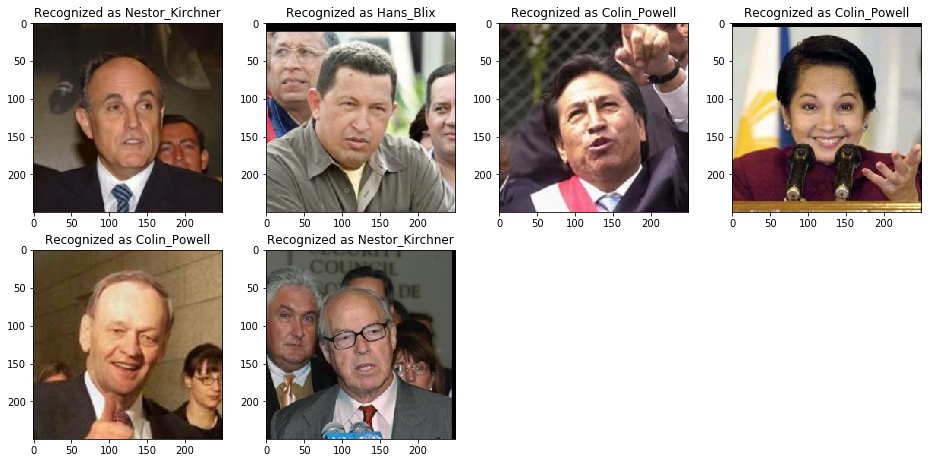

In [35]:
error_pairs = []

for i, item in enumerate(y_pred_knn):
    if item != y_test[i]:
        error_pairs.append(i)
        print(item)
        
print(error_pairs)

%matplotlib inline
show_predictions_test(error_pairs)

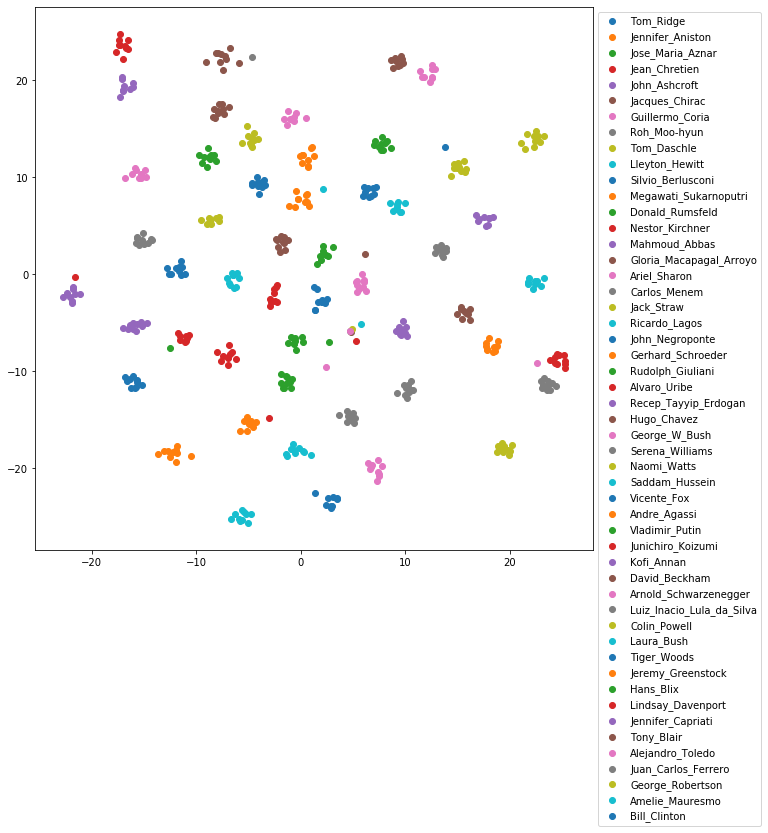

In [36]:
from sklearn.manifold import TSNE

X_embedded = TSNE(n_components=2).fit_transform(embedded)

plt.figure(figsize=(10,10))

for i, t in enumerate(set(targets)):
    idx = targets == t
    plt.scatter(X_embedded[idx, 0], X_embedded[idx, 1], label=t)   

plt.legend(bbox_to_anchor=(1, 1));

In [86]:
import smtplib
smtpObj = smtplib.SMTP_SSL("smtp.gmail.com", 465)
smtpObj.ehlo()
smtpObj.login("aaradhya271197@gmail.com", "****")
smtpObj.sendmail("aaradhya271197@gmail.com","asaxena@es.iitr.ac.in","Subject: All done.\n Yo, check the results")

-----------------------------------------

### Webcam

In [37]:
# fourcc = cv2.VideoWriter_fourcc(*'XVID')
# out = cv2.VideoWriter('output.avi',fourcc,12.0, (800,600))

In [38]:
# cap = cv2.VideoCapture(0)

# with detection_graph.as_default():
#     with tf.Session(graph=detection_graph) as sess:
#         count = 0
#         start = time.time() ###
#         while True:
#             ret, image_np = cap.read()
#             count = count + 1
#             # Expand dimensions since the model expects images to have shape: [1, None, None, 3]
#             image_np_expanded = np.expand_dims(image_np, axis=0)
#             image_tensor = detection_graph.get_tensor_by_name('image_tensor:0')
#             # Each box represents a part of the image where a particular object was detected.
#             boxes = detection_graph.get_tensor_by_name('detection_boxes:0')
#             # Each score represent how level of confidence for each of the objects.
#             # Score is shown on the result image, together with the class label.
#             scores = detection_graph.get_tensor_by_name('detection_scores:0')
#             classes = detection_graph.get_tensor_by_name('detection_classes:0')
#             num_detections = detection_graph.get_tensor_by_name('num_detections:0')
#             # Actual detection.
#             (boxes, scores, classes, num_detections) = sess.run(
#                 [boxes, scores, classes, num_detections],
#                 feed_dict={image_tensor: image_np_expanded})
#             # Visualization of the results of a detection.
#             vis_util.visualize_boxes_and_labels_on_image_array(
#                 image_np,
#                 np.squeeze(boxes),
#                 np.squeeze(classes).astype(np.int32),
#                 np.squeeze(scores),
#                 category_index,
#                 use_normalized_coordinates=True,
#                 line_thickness=8)
#             fr = cv2.resize(image_np, (800,600))
#             cv2.imshow('object detection',fr)
#             out.write(fr)
#             if cv2.waitKey(25) & 0xFF == ord('q'):
#                 cap.release()
#                 out.release()
#                 cv2.destroyAllWindows()
#                 break
#         end = time.time()
#         seconds = end - start
#         print("Time taken : {0} seconds".format(seconds))
#         # Calculate frames per second
#         fps  = count / seconds;
#         print("Estimated frames per second : {0}".format(fps))

Time taken : 80.12856459617615 seconds
Estimated frames per second : 12.791942613295166


--------------------------